In [83]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer, normalize
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold, train_test_split

%matplotlib inline

# Setting some default graph styles
sns.set_style("white", {'axes.edgecolor': '#b2b2b2'})
sns.set_context("notebook", font_scale=1.25)

In the initial analysis of the data documentation, it became clear that the data made extensive use of the value 'NA' to indicate that a feature of the house was not present.  For instance, the Garage Finish feature is described thusly:

Garage Finish (Ordinal)	: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage


In this case 'NA' does not mean "no data about the Garage Finish was recorded".  It means "we know that this house does not have a garage, therefore there is no data about the Garage Finish".  This is an important distinction as the NA value does indeed tell us something about the house.  

That being said, let's remove 'NA' from the list of things Pandas looks for when deciding if a field is empty.

In [74]:
# Redifining the list of items Pandas considers empty

na_list = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan',
    '1.#IND', '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan',
    'null']

In [75]:
housing = pd.read_csv('AmesHousing.tsv', '\t', 
                      na_values=na_list, keep_default_na=False)

In [76]:
housing.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NA,IR1,Lvl,...,0,NA,NA,NA,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NA,Reg,Lvl,...,0,NA,MnPrv,NA,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NA,IR1,Lvl,...,0,NA,NA,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NA,Reg,Lvl,...,0,NA,NA,NA,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NA,IR1,Lvl,...,0,NA,MnPrv,NA,0,3,2010,WD,Normal,189900


In [30]:
def transform_features(df):
    
    # Removing columns with more than 25% missing values
    
    missing_vals = df.isnull().sum()
    missing_vals = missing_vals[missing_vals > 0]
    missing_vals = missing_vals.apply(lambda x: x / df.shape[0] * 100)
    
    df = df.drop(missing_vals[missing_vals > 25].index, axis=1)
    
    return df

In [12]:
def select_features(df):
    
    return df[['Gr Liv Area', 'SalePrice']]

In [15]:
def train_and_test():
    
    train = select_features(housing[:1460])
    test = select_features(housing[1460:])
    
    lr = LinearRegression()
    
    lr.fit(train.select_dtypes(include=['float64', 'int64']), train['SalePrice'])
    
    prediction = lr.predict(test.select_dtypes(include=['float64', 'int64']))
    
    rmse = mean_squared_error(test['SalePrice'], prediction) ** .5
    
    return rmse

# Data Analysis and Cleaning

First let's see how the data looks with regard to missing values.

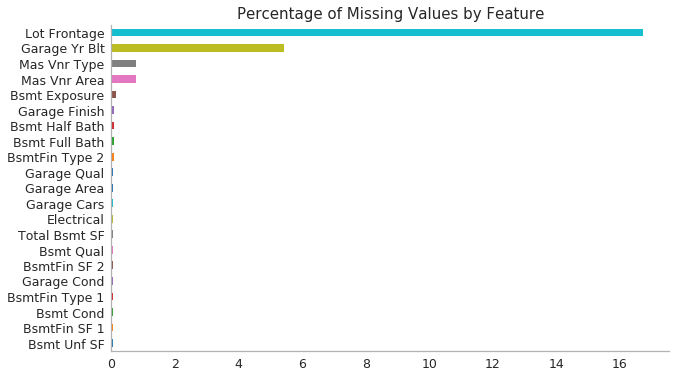

In [72]:
def missing_data(df, thresh=None):

    missing_vals = df.isnull().sum()
    missing_vals = missing_vals[missing_vals > 0]
    missing_vals = missing_vals.apply(lambda x: x / df.shape[0] * 100)
    
    if thresh:
        
        missing_vals = missing_vals[missing_vals > thresh]
    
    missing_vals = missing_vals.sort_values()
    
    return missing_vals
  
    
missing_data(housing).sort_values().plot(kind='barh', figsize=(10,6))    
plt.title('Percentage of Missing Values by Feature')
sns.despine()

The data documentation states the following about these features:

* Lot Frontage (Continuous): Linear feet of street connected to property
* Garage Yr Blt (Discrete): Year garage was built
* Mas Vnr Type (Nominal): Masonry veneer type
* Mas Vnr Area (Continuous): Masonry veneer area in square feet
* Bsmt Exposure	(Ordinal): Refers to walkout or garden level walls
* Garage Finish (Ordinal)	: Interior finish of the garage
* Bsmt Half Bath (Discrete): Basement half bathrooms
* Bsmt Full Bath (Discrete): Basement full bathrooms
* BsmtFinType 2	(Ordinal): Rating of basement finished area (if multiple types)
* Garage Qual (Ordinal): Garage quality
* Garage Area (Continuous): Size of garage in square feet
* Garage Cars (Discrete): Size of garage in car capacity
* Electrical (Ordinal): Electrical system
* Total Bsmt SF (Continuous): Total square feet of basement area
* Bsmt Qual (Ordinal): Evaluates the height of the basement
* BsmtFin SF 2 (Continuous): Type 2 finished square feet
* Garage Cond (Ordinal): Garage condition
* BsmtFin Type 1 (Ordinal): Rating of basement finished area
* Bsmt Cond (Ordinal): Evaluates the general condition of the basement
* BsmtFin SF 1 (Continuous): Type 1 finished square feet
* Bsmt Unf SF (Continuous): Unfinished square feet of basement area


imputer = Imputer(strategy='mean')

for feat in missing_cont:
    
    housing[feat] = imputer.fit_transform(housing[feat].values.reshape(-1, 1))

In [81]:
housing['Bsmt Exposure'].value_counts(dropna=False)

No     1906
Av      418
Gd      284
Mn      239
NA       79
NaN       4
Name: Bsmt Exposure, dtype: int64

Special Cases

Electrical

Bsmt Half Bath
Bsmt Full Bath
Garage Cars

In [95]:
myre = re.compile("^Bsmt.*")

bsmt_feat = [name for name in housing.columns if myre.match(name)]


In [98]:
for feat in bsmt_feat:
    
    print(housing[feat].value_counts(dropna=False))

TA     1283
Gd     1219
Ex      258
Fa       88
NA       79
Po        2
NaN       1
Name: Bsmt Qual, dtype: int64
TA     2616
Gd      122
Fa      104
NA       79
Po        5
Ex        3
NaN       1
Name: Bsmt Cond, dtype: int64
No     1906
Av      418
Gd      284
Mn      239
NA       79
NaN       4
Name: Bsmt Exposure, dtype: int64
GLQ    859
Unf    851
ALQ    429
Rec    288
BLQ    269
LwQ    154
NA      79
NaN      1
Name: BsmtFin Type 1, dtype: int64
0.0       930
24.0       27
16.0       14
300.0       9
288.0       8
384.0       8
20.0        8
600.0       8
456.0       7
360.0       7
602.0       7
375.0       7
624.0       7
936.0       7
700.0       7
500.0       7
544.0       6
504.0       6
468.0       6
625.0       6
547.0       6
662.0       6
528.0       6
560.0       6
553.0       6
368.0       6
120.0       6
276.0       6
588.0       6
312.0       6
         ... 
1151.0      1
1531.0      1
2085.0      1
1011.0      1
771.0       1
670.0       1
1239.0      1
1330.0     